# CG EDAV.. commented histograms and some power transformations of interest

In [1]:
import os
import numpy as np
import xarray as xr

from plotly import tools
from plotly import offline
import plotly.graph_objs as go

#import cufflinks as cf
#cf.set_config_file(offline=True)

In [2]:
import matplotlib.pyplot as plt

In [3]:
import os
os.getcwd()

'C:\\Users\\goyetc\\capstone_private'

# $\textbf{pCO}_2$ testbed - member 001 dataset

This contains model output from member 001 of the CESM large ensemble which can be used to evaluate ocean pCO2 interpolation methods. The dataset includes:

* pCO2 = ocean partial pressure of carbon dioxide (uatm)
* XCO2 = atmospheric carbon dioxide mixing ratio (ppmv)
* SST = sea surface temperature (degC)
* SSS = sea surface salinity (g/kg)
* MLD = mixed layer depth (m)
* CHL = chlorophyll concentration (mg/m3)

# Read each feature

In [4]:
DATA_DIR = 'C:\\Users\\goyetc\\ocean-co2-absorption\\data'
dataset_names = {'pCO2': 'pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
                 'XCO2': 'XCO2_1D_mon_CESM001_native_198201-201701.nc',
                 'SST': 'SST_2D_mon_CESM001_1x1_198201-201701.nc',
                 'SSS': 'SSS_2D_mon_CESM001_1x1_198201-201701.nc',
                 'MLD': 'MLD_2D_mon_CESM001_1x1_198201-201701.nc',
                 'Chl': 'Chl_2D_mon_CESM001_1x1_198201-201701.nc'}
ds = {}
for dataset in dataset_names.keys():
    filename = os.path.join(DATA_DIR, dataset_names[dataset])
    ds[dataset] = xr.open_dataset(filename)

# Print information of each dataset

In [ ]:
for dataset in ds.keys():
    print("---------{}---------".format(dataset))
    print(ds[dataset].info())

## Convert xarray data to dataframe

##### Note: For consistency and not to reproduce work, using code from Lingyun's 'edav first pass' notebook to produce dataframes from .nc files

* Select corresponding features from each dataset: for example, `df['pCO2']` has both variables `pCO2_socat` (pCO2 just at SOCAT locations) and `pCO2`, so both of the two features will be converted to dataframe
* Only keep grids with finite values
* Convert pivot table to flat dataframe

In [5]:
df = {}
df_socat = {}
for dataset in ds.keys():
    # e.g. pCO2
    df[dataset] = ds[dataset][dataset].to_dataframe()
    
    #note np.isfinite eliminates infinite and/or NaN records from dataset 
    df[dataset] = df[dataset][np.isfinite(df[dataset][dataset])].reset_index()


## SSS Plots
* Pseudo-gaussian distribution, note significant peak in histogram
* Upon Further inspection, distribution is far less normally distributed than first observed, with what might be described as abnormal left skew
* Almost cauchy-esque in nature.. interesting to think about

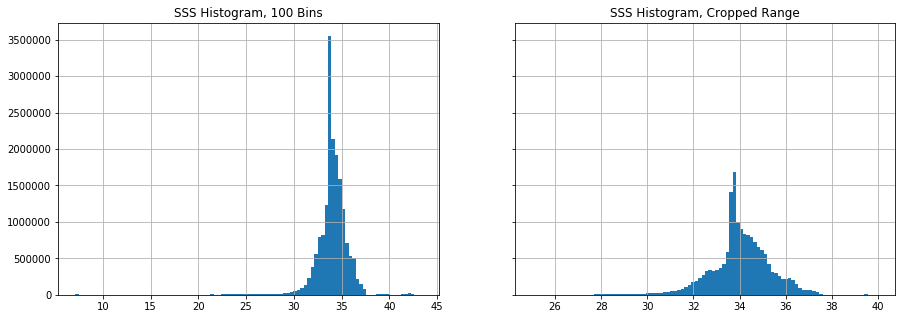

In [9]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['SSS']['SSS'].hist(ax=axs[0],bins=100).set_title('SSS Histogram, 100 Bins')
df['SSS']['SSS'].hist(ax=axs[1],bins=100,range=(25,40)).set_title('SSS Histogram, Cropped Range')

fig.show()

#plt.hist(df['SSS']['SSS'], 100)
#plt.title('SSS')
#plt.show()

## SST Plots
* Odd, non-normal distribution. Two-tails.. reminiscent of a superposition of multiple distributions (e.g., log-normal/gamma, or generally beta-esque (right tail)) 
* What is appropriate way to transform this data for improved uncertainty during modeling process?

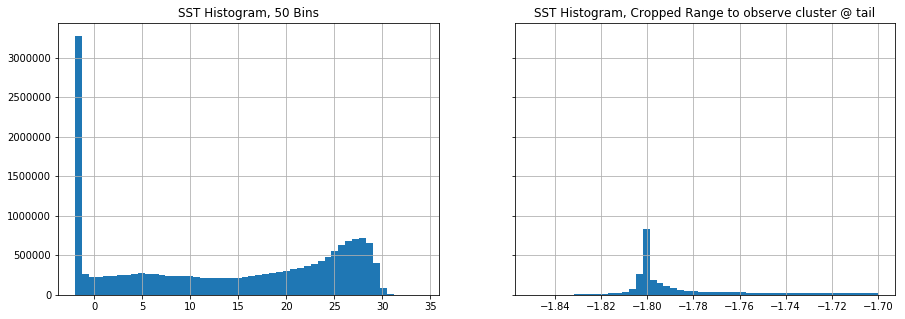

In [32]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['SST']['SST'].hist(ax=axs[0],bins=50).set_title('SST Histogram, 50 Bins')
df['SST']['SST'].hist(ax=axs[1],bins=50,range = (-1.85,-1.7)).set_title('SST Histogram, Cropped Range to observe cluster @ tail')

fig.show()

## MLD Plots
* Note right skew, approximately normal or perhaps log-normal
* Eval power transforms

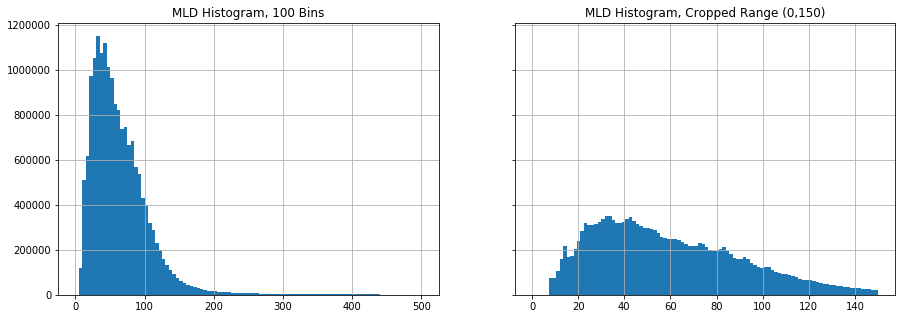

In [40]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['MLD']['MLD'].hist(ax=axs[0],bins=100, range=(0,500)).set_title('MLD Histogram, 100 Bins')
df['MLD']['MLD'].hist(ax=axs[1],bins=100,range=(0,150)).set_title('MLD Histogram, Cropped Range (0,150)')

fig.show()

## CHL Plots
* Data has extremely long tail, but 2nd and 3rd quartiles are bound to ~[0.1,0.2]. 
* Note two peaks, non-normal distribution upon more granular inspection, combined with what looks like log-normal behavior approaching left tail of dis
* Strong evidence of non-linear behavior

In [50]:
df['Chl']['Chl'].describe()

count    1.729047e+07
mean     3.449500e-01
std      8.521562e-01
min     -4.092084e-01
25%      1.087646e-01
50%      1.580932e-01
75%      2.111136e-01
max      1.467028e+01
Name: Chl, dtype: float64

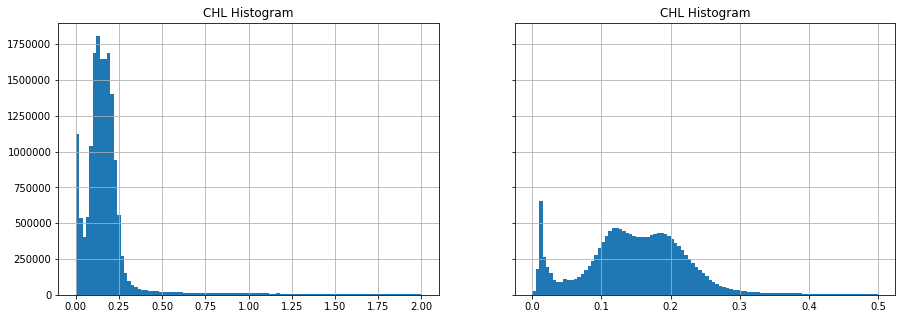

In [78]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['Chl']['Chl'].hist(ax=axs[0],bins=100, range=(0,2)).set_title('CHL Histogram')
df['Chl']['Chl'].hist(ax=axs[1],bins=100,range=(0,0.5)).set_title('CHL Histogram')

fig.show()

## XCO2 Plots
* Atmospheric co2 measurements, monthly frequency 
* Odd gap in measurements at value 380
* Note that amount of data points is far smaller here, as this is not spatially evaluated. Simply time-dependent atomospheric estimate

In [52]:
df['XCO2']['XCO2'].describe()

count    421.000000
mean     370.185059
std       18.717714
min      340.848541
25%      354.770691
50%      368.160828
75%      385.430237
max      407.208405
Name: XCO2, dtype: float64

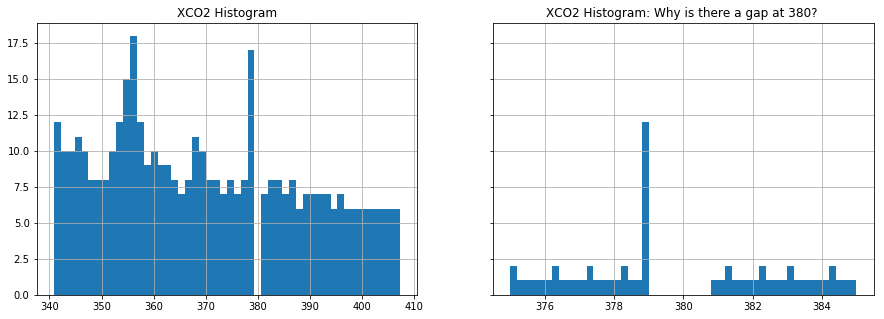

In [58]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['XCO2']['XCO2'].hist(ax=axs[0],bins=50).set_title('XCO2 Histogram')
df['XCO2']['XCO2'].hist(ax=axs[1],bins=50,range=(375,385)).set_title('XCO2 Histogram: Why is there a gap at 380? ')

fig.show()

## pCO2 Plots
* Flux,CO2 data product 
* Relatively normally distributed.. 

In [59]:
df['pCO2']['pCO2'].describe()

count    1.729047e+07
mean     3.473385e+02
std      4.455926e+01
min      1.082504e+02
25%      3.275315e+02
50%      3.491305e+02
75%      3.714645e+02
max      8.311137e+02
Name: pCO2, dtype: float64

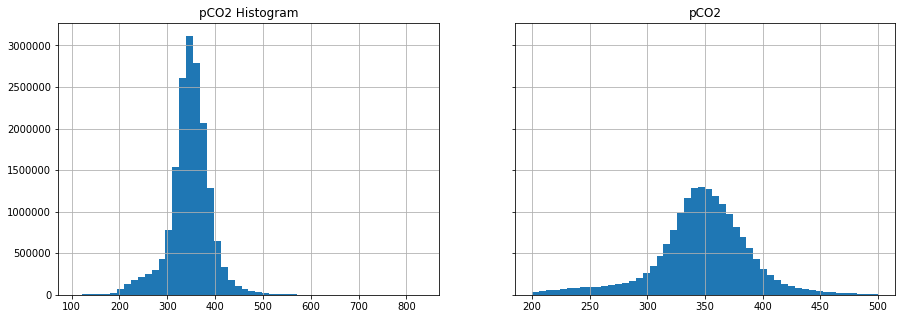

In [61]:
fig, axs = plt.subplots(1,2,sharey=True, figsize =[15,5])

df['pCO2']['pCO2'].hist(ax=axs[0],bins=50).set_title('pCO2 Histogram')
df['pCO2']['pCO2'].hist(ax=axs[1],bins=50,range=(200,500)).set_title('pCO2', cropped range)

fig.show()

## Power Transforms
##### In the interest of describing the distributions of the driver data more detail, power transformations are performed for MLD and SSS
* lambda = -1. is a reciprocal transform.
* lambda = -0.5 is a reciprocal square root transform.
* lambda = 0.0 is a log transform.
* lambda = 0.5 is a square root transform.
* lambda = 1.0 is no transform.

In [16]:
from scipy.stats import boxcox

In [63]:
df.keys()

dict_keys(['pCO2', 'XCO2', 'SST', 'SSS', 'MLD', 'Chl'])

In [109]:
#power transformations of MLD
len = df['MLD'].shape[0]
#p_MLD = np.empty([len,5])
p_MLD = {}
lambda_list = [-0.5,0,0.5]
for i in range(3):
    p_MLD['power:'+str(lambda_list[i])] = boxcox(df['MLD']['MLD'],lambda_list[i])

In [110]:
#power transformations of SSS
len = df['SSS'].shape[0]
#p_MLD = np.empty([len,5])
p_SSS = {}
lambda_list = [-0.5,0,0.5]
for i in range(3):
    p_SSS['power:'+str(lambda_list[i])] = boxcox(df['SSS']['SSS'],lambda_list[i])

In [111]:
df_MLD_powers = pd.DataFrame.from_dict(p_MLD, orient = 'columns')
df_SSS_powers = pd.DataFrame.from_dict(p_SSS, orient = 'columns')

## MLD transforms

* log or square root both reasonable choices.. log(MLD) is historical choice by Landschutzer and others
* Note that in general, we are hesitant to transform the driver data, as we want to minimize bias in our models at all costs. This may result in reduced model performance (aka higher uncertainty) than for a model based on transformed data, but such is life

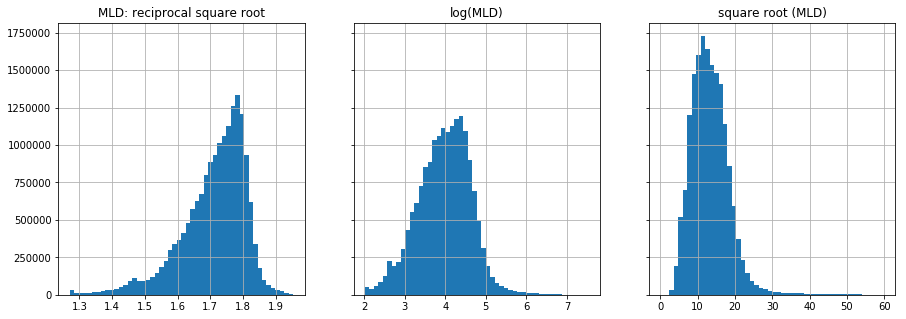

In [113]:
fig, axs = plt.subplots(1,4,sharey=True, figsize =[15,5])

df_MLD_powers['power:-0.5'].hist(ax=axs[0],bins=50,label='reciprocal square root').set_title('MLD: reciprocal square root')
df_MLD_powers['power:0'].hist(ax=axs[1],bins=50,label='log').set_title('log(MLD)')
df_MLD_powers['power:0.5'].hist(ax=axs[2],bins=50,range=(0,60),label='square root').set_title('square root (MLD)')
  
fig.show()

#### SST Power Transformations
* Frankly, power transformations cannot resolve the weird distribution of SSS. Suspect multiple underlying drivers at play here

In [25]:
df_SSS_powers.describe()

,power:-0.5,power:0,power:0.5
count,1.729047e+07,1.729047e+07,1.729047e+07
mean,1.656470e+00,3.524549e+00,9.657170e+00
std,1.470467e-02,6.701048e-02,3.337345e-01
min,1.251403e+00,1.965404e+00,3.343331e+00
25%,1.654509e+00,3.511870e+00,9.577714e+00
50%,1.657030e+00,3.526518e+00,9.662820e+00
75%,1.661043e+00,3.550061e+00,9.800922e+00
max,1.696221e+00,3.769203e+00,1.116746e+01


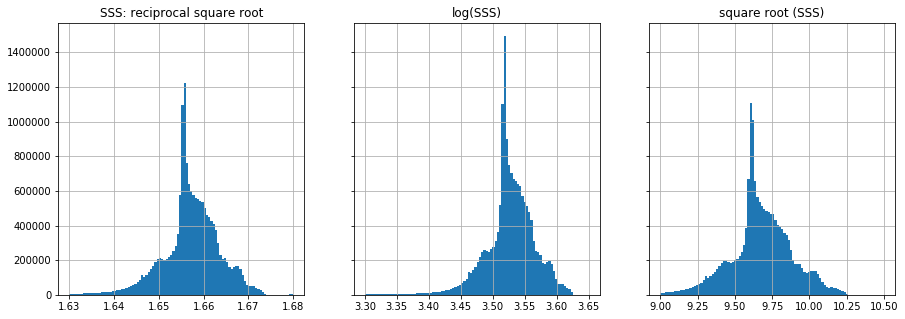

In [118]:
fig, axs = plt.subplots(1,3,sharey=True, figsize =[15,5])

df_SSS_powers['power:-0.5'].hist(ax=axs[0],bins=100,range=(1.63,1.68),label='reciprocal square root').set_title('SSS: reciprocal square root')
df_SSS_powers['power:0'].hist(ax=axs[1],bins=100,range=(3.3,3.65),label='log').set_title('log(SSS)')
df_SSS_powers['power:0.5'].hist(ax=axs[2],bins=100,range=(9,10.5),label='square root').set_title('square root (SSS)')
  
fig.show()

##### Errata.. attempted to script power transforms for all var, but quickly realized could not do so because many contain values <0. Wasn't worth the time. 

In [97]:
#power transformations
powers = {}
df_powers = []
for item in df.keys():
    
    if item in ('XCO2','pCO2','SST','Chl'):
        pass
    else:
        
        len = df[item].shape[0]

        powers[item] = {}
        lambda_list = [-0.5,0,0.5]
        for i in range(3):
            powers[item]['power:'+str(lambda_list[i])] = boxcox(df[item][item],lambda_list[i])

df_powers = pd.DataFrame.from_dict(powers, orient = 'columns') 